# DataSet e bibliotecas a serem usados no projeto

In [46]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import jax as jax
from typing import Callable
from sklearn.model_selection import train_test_split
import time
import timeit
import matplotlib.pyplot as plt

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

In [47]:
print(data.columns.tolist())

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']


# Separação dos dados de treino e teste, normalização e conversão para arrays de JAX

In [48]:
def normalizeData(data):
    #Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
    means = jnp.mean(data, axis=0)
    normalizedData = data - means

    # dataMin = jnp.min(data, axis=0)
    # dataMax = jnp.max(data, axis=0)
    
    # normalizedData = (data - dataMin) / (dataMax - dataMin)
    
    return normalizedData

# Separando dados de treino e de teste
features = data.columns.tolist()[:-1]
x = data[[feature for feature in features]]  
y = data['target']  
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Convertendo para arrays compatíveis com JAX:
xTrain = normalizeData(jnp.array(xTrain))
xTest = normalizeData(jnp.array(xTest))
yTrain = jnp.array(yTrain)
yTest = jnp.array(yTest)

# Definição de funções que usaremos ao longo da tarefa: knn, pca, medidas de distância e medidas de eficácia do algoritmo

In [49]:
def norm1(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=1)

def norm2(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=2)

def normInf(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=jnp.inf)

def getMetric(metricId:str) -> float:
    """Retorna um método de cálculo de distâncias em função da string passada.

    Args:
        metricId (str): Nome ou Id da norma ou método de cálculo de distância entre dois pontos.

    Returns:
        float: Distância ou norma.
    """
    match metricId:
        case 'norm1':
            _metric = norm1
        case 'norm2':
            _metric = norm2
        case 'normInf':
            _metric = normInf

    return _metric
    
    
def computeAccuracy(predictions:jnp.ndarray, actualLabels:jnp.ndarray) -> float:
    """Calcula a acurácia do modelo de classificação em porcentagem de acertos.

    Args:
        predictions (jnp.ndarray): Array com classificação estimada para os pontos de teste.
        actualLabels (jnp.ndarray): Array com classificação correta dos pontos de teste. 

    Returns:
        float: Porcentagem de acertos.
    """
    correct_predictions = jnp.sum(predictions == actualLabels)
    accuracy = correct_predictions / actualLabels.size
    
    return accuracy

Aqui, implementamos o PCA usando a decomposição total da matriz de covariância dos dados. O interesse desse método no entanto estaria no cálculo iterativo dos valores principais, de forma a obter apenas os k-primeiros singular values e right singular vectors, economizando recursos e tempo.

Parar fins de comparação, implementei o PCA com SVD e com decomposição em autovalores e autovetores. Como a matriz de covariância é simétrica, sabemos que as duas decomposições, se feitas em sua totalidade, devem nos dar o mesmo resultado. No entanto, por enquanto isso não está acontecendo e ainda não achei a causa.

In [50]:
def pca(data:jnp.ndarray, numComponents:int, svd=True) -> jnp.ndarray:
    """
    A partir de um conjunto de dados, retorna a matriz de projeção para as k componentes principais.

    Args:
        data (jnp.ndaaray): Dados para reduzir dimensionalidade.
        numComponents (int): Número de componentes desejadas na projeção.

    Returns:
        jnp.ndarray: Matriz de projeção.
    """

    covarianceMatrix = (1/len(data)) * data.T @ data
    
    if svd:
        # Realizando a decomposição em valores singulares. U terá vetores coluna ortogonais.  
        # A pricípio, o ordenamento não é necessário pois svd() já retorna os valores principais ordenados.  
        U, S, Ut = jax.scipy.linalg.svd(covarianceMatrix) 
        indices = jnp.argsort(S, descending=True)
        projectionMatrix = U[:,:numComponents][indices]
    else:
        # Decomposição a partir de autovalores e autovetores.
        # Aqui, o ordenamento dos autovetores baseado nos autovalores é necessário.
        eigenvalues, eigenvectors = jnp.linalg.eig(covarianceMatrix)  
        indices = jnp.argsort(eigenvalues, descending=True)           
        projectionMatrix = eigenvectors[:numComponents][indices]  

   

    return projectionMatrix


Entender como funciona a vetorização de métodos no JAX demorou um pouco, mas no final deu certo. A fim de ter certeza que a implementação está correta, rodei o KNN pelo scikit-learn e obtive a mesma acurácia para diversos valores de k.

In [51]:
def knn(xTrain:jnp.ndarray, yTrain:jnp.ndarray, xTest:jnp.ndarray, k:int, metric:Callable[[jnp.ndarray, jnp.ndarray], float]) -> jnp.ndarray:
    """ Implementa a classificação de um conjunto de dados a partir do algoritmo de K-Nearest Neighbors (KNN).

    Args:
        xTrain (jnp.ndarray): Dados de treino
        yTrain (jnp.ndarray): Labels para os dados de treino
        xTest (jnp.ndarray): Dados de teste
        k (int): Número de vizinhos mais próximos usados para a classificação.
        metric (Callable): Função que calcula distância entre dois pontos.

    Returns:
        jnp.ndarray: Array contendo as predições realizadas para o conjunto de dados de teste xTest.
    """
    
    # Implementação JAX-friendly do cálculo da matriz de distâncias para um conjunto de pontos de teste.
    # O cálculo da matriz é feito vetorizando duas vezes a função de métrica, para calcular dois a dois
    # as distâncias entre pontos de treino e de teste.
    distances = jax.vmap(lambda train_point: jax.vmap(metric, in_axes=(None, 0))(train_point, xTest))(xTrain)

    # Ordenando as distâncias entre pontos, e pegando os targets/labels dos k pontos mais próximos para cada ponto de treino
    sorted_indices = jnp.argsort(distances, axis=0)
    nearestNeighborsIndices = sorted_indices[:k, :]
    nearestNeighbors = yTrain[nearestNeighborsIndices].astype(int)

    # Contagem dos números de cada target presente na lista de vizinhos próximos e definição do target estimado para o ponto
    # de teste baseado numa voto de maioria.
    totalLabels = 3
    targetCounts = jax.vmap(lambda neighbors: jnp.bincount(neighbors, minlength=totalLabels, length=3))(nearestNeighbors.T) 
    most_common_classes = jnp.argmax(targetCounts, axis=1)
    
    return most_common_classes


# Implementação do KNN sem redução de dimensionalidade

Afim de estudar a influência de cada um dos parâmetros do algoritmo, vamos rodá-lo usando algumas normas diferentes e para diversos números de vizinhos.

In [52]:
accuracy = {}
elapsedTimes = {}
metrics=['norm1', 'norm2', 'normInf']
neighbors = [i for i in range(0,20) if i%3 != 0]

for metric in metrics:
    accuracy[metric] = []
    elapsedTimes[metric] = []
    for neighbor in neighbors:
            
        distance = getMetric(metric)
        
        startTime = time.time()
        predictions = knn(xTrain, yTrain, xTest, neighbor, distance)
        endTime = time.time()
        
        acc = computeAccuracy(predictions, yTest)
        accuracy[metric].append(acc.item())
        elapsedTimes[metric].append(endTime - startTime)

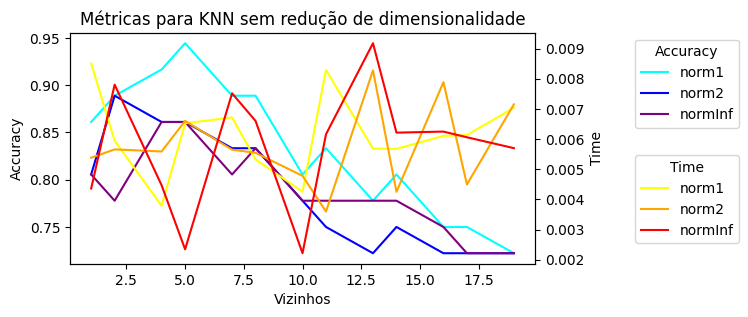

In [53]:
# Criando plots com métricas para o algoritmos
fig, ax1 = plt.subplots(figsize=(6, 3))
ax2 = ax1.twinx()
plt.title('Métricas para KNN sem redução de dimensionalidade')

# Plotando dados de acurácia
ax1.plot(neighbors, accuracy['norm1'], label='norm1', color='cyan')
ax1.plot(neighbors, accuracy['norm2'], label='norm2', color='blue')
ax1.plot(neighbors, accuracy['normInf'], label='normInf', color='purple')
ax1.set_xlabel('Vizinhos')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plotando dados de tempo de execução
ax2.plot(neighbors, elapsedTimes['norm1'], label='norm1', color='yellow')
ax2.plot(neighbors, elapsedTimes['norm2'], label='norm2', color='orange')
ax2.plot(neighbors, elapsedTimes['normInf'], label='normInf', color='red')
ax2.set_ylabel('Time', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax1.legend(title='Accuracy', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.legend(title='Time', loc='upper left', bbox_to_anchor=(1.2, 0.5))


Podemos observar, como esperado, que parece haver um número ótimo de vizinhos a se considerar para a classificação. Interessante notar que não somente esse número depende da norma escolhida, mas também que a norma-1 obteve um resultado melhor que as outras consistentemente para todos os valores de k.

Podemos rodar a função 100 vezes para obter uma medida de velocidade de execução do algoritmo, para comparar com a versão de dimesão reduzida posteriormente.

In [37]:
k=3
runs = 100
execution_time = timeit.timeit(lambda: knn(xTrain, yTrain, xTest, k, distance), number=runs)
print("Tempo médio de execução:", execution_time/runs)

Tempo médio de execução: 0.005569527999032289


## Comparação com implementação usando scikit learn para fins de check de sanidade

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k = 3
knnClassifier = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
knnClassifier.fit(xTrain, yTrain)
predictions = knnClassifier.predict(xTest)

accuracy = accuracy_score(yTest, predictions)
accuracy

0.8888888888888888

# Implementação do KNN com redução de dimensionalidade por meio de Principal Component Analysis (PCA) com SVD e decomposição espectral

In [39]:
distance = getMetric('norm1')
k=3
numComponents = 13

useSvd = True

xTrainReducedDim = xTrain @ pca(xTrain, numComponents, svd=useSvd) 
xTestReducedDim = xTest @ pca(xTest, numComponents, svd=useSvd)

print(xTrain.shape)
print(xTest.shape)

print(xTrainReducedDim.shape)
print(xTestReducedDim.shape)

startTime = time.time()
predictions = knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance)
endTime = time.time()
print("elapsed time:", endTime - startTime)

acc = computeAccuracy(predictions, yTest)
acc.item()


(142, 13)
(36, 13)
(142, 13)
(36, 13)
elapsed time: 0.007608652114868164


0.8333333134651184

In [41]:
accuracy = {}
elapsedTimes = {}
k=3
numComponents = 13
useSvd = True
metrics=['norm1', 'norm2', 'normInf']

for metric in metrics:
    accuracy[metric] = []
    elapsedTimes[metric] = []
    for nbComponents in range(1, 13):
    
        
        distance = getMetric(metric)
        
        xTrainReducedDim = xTrain @ pca(xTrain, nbComponents, svd=useSvd)
        xTestReducedDim = xTest @ pca(xTest, nbComponents, svd=useSvd)

        startTime = time.time()
        predictions = knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance)
        endTime = time.time()
        
        acc = computeAccuracy(predictions, yTest)
        accuracy[metric].append(acc.item())
        elapsedTimes[metric].append(endTime - startTime)

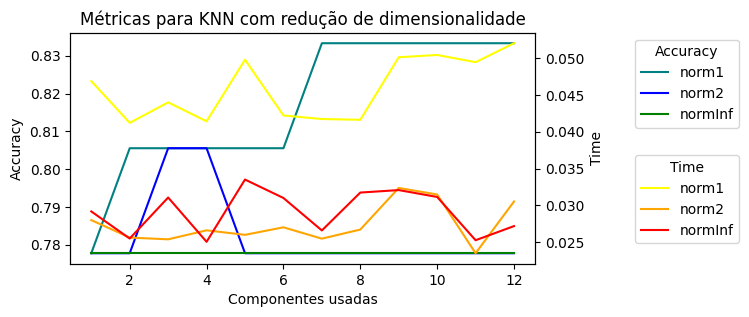

In [44]:
# Criando plots com métricas para o algoritmos
components = range(1, 13)
fig, ax1 = plt.subplots(figsize=(6, 3))
ax2 = ax1.twinx()
plt.title('Métricas para KNN com redução de dimensionalidade')

# Plotando dados de acurácia
ax1.plot(components, accuracy['norm1'], label='norm1', color='teal')
ax1.plot(components, accuracy['norm2'], label='norm2', color='blue')
ax1.plot(components, accuracy['normInf'], label='normInf', color='green')
ax1.set_xlabel('Componentes usadas')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plotando dados de tempo de execução
ax2.plot(components, elapsedTimes['norm1'], label='norm1', color='yellow')
ax2.plot(components, elapsedTimes['norm2'], label='norm2', color='orange')
ax2.plot(components, elapsedTimes['normInf'], label='normInf', color='red')
ax2.set_ylabel('Time', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax1.legend(title='Accuracy', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.legend(title='Time', loc='upper left', bbox_to_anchor=(1.2, 0.5))

In [43]:
k=3
runs = 100
execution_time = timeit.timeit(lambda: knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance), number=runs)
print("Tempo médio de execução:", execution_time/runs)

Tempo médio de execução: 0.005660597999813035
